# Step 1: Download US Stock & Bond Returns

In [27]:
import pandas as pd
import numpy as np
import yfinance as yf
import time
import requests
from pathlib import Path
import pandas as pd
import numpy as np
import openpyxl


print("=" * 80)
print("DOWNLOADING MONTHLY RETURNS: S&P 500 TR + IEF TREASURY TR + T-BILL (DTB3)")
print("=" * 80)

# 1) S&P 500 Total Return index from Yahoo Finance
sp_ticker = "^SP500TR"
sp_daily = yf.download(sp_ticker, auto_adjust=True, progress=False)

def fetch_yahoo_chart_monthly(ticker: str) -> pd.Series:
    url = f"https://query1.finance.yahoo.com/v8/finance/chart/{ticker}"
    params = {"interval": "1mo", "range": "max"}
    headers = {"User-Agent": "Mozilla/5.0"}
    for attempt in range(3):
        resp = requests.get(url, params=params, headers=headers, timeout=30)
        if resp.status_code == 429:
            time.sleep(2 ** (attempt + 1))
            continue
        resp.raise_for_status()
        data = resp.json()
        result = data.get("chart", {}).get("result", [])
        if not result:
            return pd.Series(dtype=float)
        timestamps = result[0].get("timestamp", [])
        indicators = result[0].get("indicators", {})
        adj = indicators.get("adjclose", [])
        closes = indicators.get("quote", [])
        values = None
        if adj and "adjclose" in adj[0]:
            values = adj[0].get("adjclose", [])
        elif closes and "close" in closes[0]:
            values = closes[0].get("close", [])
        if not timestamps or values is None:
            return pd.Series(dtype=float)
        idx = pd.to_datetime(pd.Series(timestamps), unit="s")
        series = pd.Series(values, index=idx).dropna()
        return series
    return pd.Series(dtype=float)

if sp_daily.empty:
    sp_series = pd.Series(dtype=float)
else:
    sp_series = sp_daily["Close"].resample("ME").last()

# Fallback to Yahoo chart API if too short
if sp_series.dropna().shape[0] < 24:
    sp_series = fetch_yahoo_chart_monthly("%5ESP500TR")

if sp_series.empty:
    raise ValueError("Yahoo Finance returned no data for ^SP500TR (rate-limited or unavailable)")

us_stock_returns = sp_series.pct_change().dropna()
us_stock_returns.name = "US_Stocks"

# 2) 3-Month T-Bill yield from FRED (DTB3) - for risk-free rate
tbill_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?id=DTB3"
tbill_daily = pd.read_csv(tbill_url)
if tbill_daily.empty:
    raise ValueError("FRED returned no data for DTB3")

# Handle varying column names from FRED
tbill_date_col = "DATE" if "DATE" in tbill_daily.columns else tbill_daily.columns[0]
tbill_value_col = "DTB3" if "DTB3" in tbill_daily.columns else tbill_daily.columns[-1]

tbill_daily[tbill_date_col] = pd.to_datetime(tbill_daily[tbill_date_col], errors="coerce")
tbill_daily[tbill_value_col] = pd.to_numeric(tbill_daily[tbill_value_col], errors="coerce")
tbill_daily = tbill_daily.dropna(subset=[tbill_date_col, tbill_value_col]).set_index(tbill_date_col)

# Monthly average yield, convert to decimal and approximate monthly risk-free rate
tbill_monthly_yield = tbill_daily[tbill_value_col].resample("ME").mean() / 100.0

# 3) US Bonds total return proxy (IEF: 7-10Y Treasury ETF) from Yahoo Finance
bond_ticker = "IEF"
bond_daily = yf.download(bond_ticker, auto_adjust=True, progress=False)

if bond_daily.empty:
    bond_series = fetch_yahoo_chart_monthly(bond_ticker)
else:
    bond_series = bond_daily["Close"].resample("ME").last()

if bond_series.dropna().shape[0] < 24:
    bond_series = fetch_yahoo_chart_monthly(bond_ticker)

if bond_series.empty:
    raise ValueError("Yahoo Finance returned no data for IEF")

us_bond_returns = bond_series.pct_change().dropna()
us_bond_returns.name = "US_Bonds"

# Normalize indices to month-end for alignment
us_stock_returns.index = us_stock_returns.index.to_period("M").to_timestamp("M")
us_bond_returns.index = us_bond_returns.index.to_period("M").to_timestamp("M")
tbill_monthly_yield.index = tbill_monthly_yield.index.to_period("M").to_timestamp("M")

print(f"S&P 500 TR monthly returns: {len(us_stock_returns)} months ({us_stock_returns.index.min():%Y-%m} to {us_stock_returns.index.max():%Y-%m})")
print(f"US Bond (IEF) monthly returns: {len(us_bond_returns)} months ({us_bond_returns.index.min():%Y-%m} to {us_bond_returns.index.max():%Y-%m})")
print(f"T-Bill monthly yield series: {len(tbill_monthly_yield)} months ({tbill_monthly_yield.index.min():%Y-%m} to {tbill_monthly_yield.index.max():%Y-%m})")
print("✓ Monthly return series loaded")

DOWNLOADING MONTHLY RETURNS: S&P 500 TR + IEF TREASURY TR + T-BILL (DTB3)
S&P 500 TR monthly returns: 153 months (1988-04 to 2026-01)
US Bond (IEF) monthly returns: 281 months (2002-09 to 2026-01)
T-Bill monthly yield series: 865 months (1954-01 to 2026-01)
✓ Monthly return series loaded


# Step 2: Extract Global Stock Returns from JST Dataset

We'll load the Jordà-Schularick-Taylor Macrohistory Database and extract equity returns for all countries to create a global stock portfolio.

In [28]:
print("=" * 80)
print("LOADING JST MACROHISTORY DATABASE - GLOBAL EQUITY RETURNS")
print("=" * 80)

# Load the JST dataset
jst_file = Path.home() / "Downloads" / "JSTdatasetR6.xlsx"

try:
    # The JST dataset has headers starting at row 14 (0-indexed row 13)
    print("\nLoading JST dataset...")
    jst_data = pd.read_excel(jst_file, sheet_name='Data', header=13)
    
    print(f"✓ Successfully loaded JST dataset")
    print(f"  Shape: {jst_data.shape[0]} rows × {jst_data.shape[1]} columns")
    
    # Show actual column names
    print(f"\nColumn names found:")
    for i, col in enumerate(jst_data.columns[:15]):
        print(f"  {i}: {col}")
    if len(jst_data.columns) > 15:
        print(f"  ... and {len(jst_data.columns) - 15} more columns")
    
    # Show first few rows
    print("\nFirst few rows:")
    print(jst_data.head())
    
except Exception as e:
    print(f"✗ Error loading JST dataset: {e}")
    import traceback
    traceback.print_exc()
    jst_data = None

LOADING JST MACROHISTORY DATABASE - GLOBAL EQUITY RETURNS

Loading JST dataset...
✓ Successfully loaded JST dataset
  Shape: 2719 rows × 27 columns

Column names found:
  0: Unnamed: 0
  1: Unnamed: 1
  2: Unnamed: 2
  3: Unnamed: 3
  4: Total return
  5: Unnamed: 5
  6: Unnamed: 6
  7: Unnamed: 7
  8: Unnamed: 8
  9: Equity market
  10: Unnamed: 10
  11: Unnamed: 11
  12: Unnamed: 12
  13: Housing market
  14: Unnamed: 14
  ... and 12 more columns

First few rows:
  Unnamed: 0 Unnamed: 1         Unnamed: 2  Unnamed: 3 Total return  \
0       Year    Country  ISO 3-letter code         NaN       Equity   
1       1870  Australia                AUS         NaN    -0.003631   
2       1871  Australia                AUS         NaN     0.109847   
3       1872  Australia                AUS         NaN     0.178806   
4       1873  Australia                AUS         NaN     0.152928   

  Unnamed: 5        Unnamed: 6 Unnamed: 7  Unnamed: 8 Equity market  ...  \
0    Housing  Government bo

In [29]:
# The actual data starts from row 2 (after the sub-headers)
# Let's reload with proper structure

print("\nReloading with correct header structure...")

# Skip the first row which has category headers, use row 1 (0-indexed) as column names
jst_data = pd.read_excel(jst_file, sheet_name='Data', header=14)

print(f"✓ Reloaded with proper headers")
print(f"  Shape: {jst_data.shape[0]} rows × {jst_data.shape[1]} columns")
print(f"\nColumn names:")
print(list(jst_data.columns))

print("\nFirst 5 rows:")
print(jst_data.head())

# Check the year and country columns
print(f"\nYear range: {jst_data['Year'].min()} to {jst_data['Year'].max()}")
print(f"Countries: {sorted(jst_data['Country'].unique())}")


Reloading with correct header structure...
✓ Reloaded with proper headers
  Shape: 2718 rows × 27 columns

Column names:
['Year', 'Country', 'ISO 3-letter code', 'Unnamed: 3', 'Equity', 'Housing', 'Government bonds', 'Bills', 'Unnamed: 8', 'Capital gain', 'Dividend return', 'Dividend yield', 'Unnamed: 12', 'Capital gain.1', 'Rental return', 'Rental yield', 'Unnamed: 16', 'USD exchange rate', 'Inflation rate', 'Gov. bond rate', 'Unnamed: 20', 'Equity.1', 'Housing.1', 'Government bonds.1', 'Bills.1', 'Unnamed: 25', 'Unnamed: 26']

First 5 rows:
   Year    Country ISO 3-letter code  Unnamed: 3    Equity  Housing  \
0  1870  Australia               AUS         NaN -0.003631      NaN   
1  1871  Australia               AUS         NaN  0.109847      NaN   
2  1872  Australia               AUS         NaN  0.178806      NaN   
3  1873  Australia               AUS         NaN  0.152928      NaN   
4  1874  Australia               AUS         NaN  0.190473      NaN   

   Government bonds   B

In [30]:
# Extract equity returns for all countries and calculate equal-weighted global average
# Column 'Equity' contains total equity returns (nominal)

print("=" * 80)
print("CALCULATING GLOBAL EQUITY RETURNS")
print("=" * 80)

# Pivot the data to have countries as columns
equity_by_country = jst_data.pivot(index='Year', columns='Country', values='Equity')

print(f"\nEquity returns matrix:")
print(f"  Years: {len(equity_by_country)} ({equity_by_country.index.min()} to {equity_by_country.index.max()})")
print(f"  Countries: {len(equity_by_country.columns)}")
print(f"\nCountries included: {', '.join(equity_by_country.columns)}")

# Calculate equal-weighted average across all countries (ignoring NaN)
global_equity_annual = equity_by_country.mean(axis=1)

print(f"\nGlobal equity returns (annual):")
print(f"  Years: {len(global_equity_annual)}")
print(f"  Mean: {global_equity_annual.mean():.4%}")
print(f"  Std Dev: {global_equity_annual.std():.4%}")
print(f"  Min: {global_equity_annual.min():.4%} (year {global_equity_annual.idxmin()})")
print(f"  Max: {global_equity_annual.max():.4%} (year {global_equity_annual.idxmax()})")

# Show data availability by country
print(f"\nData availability by country:")
availability = equity_by_country.notna().sum().sort_values(ascending=False)
for country, count in availability.items():
    start_year = equity_by_country[country].first_valid_index()
    end_year = equity_by_country[country].last_valid_index()
    print(f"  {country:15s}: {count:3d} years ({start_year}-{end_year})")

print("\n" + "=" * 80)
print("NOTE: JST data is ANNUAL. To align with monthly US data,")
print("we'll need to decide how to handle the frequency mismatch.")
print("=" * 80)

CALCULATING GLOBAL EQUITY RETURNS

Equity returns matrix:
  Years: 151 (1870 to 2020)
  Countries: 18

Countries included: Australia, Belgium, Canada, Denmark, Finland, France, Germany, Ireland, Italy, Japan, Netherlands, Norway, Portugal, Spain, Sweden, Switzerland, UK, USA

Global equity returns (annual):
  Years: 151
  Mean: 10.6271%
  Std Dev: 13.3343%
  Min: -42.8369% (year 2008)
  Max: 44.9280% (year 1983)

Data availability by country:
  Australia      : 151 years (1870-2020)
  Belgium        : 151 years (1870-2020)
  France         : 151 years (1870-2020)
  Italy          : 151 years (1870-2020)
  Sweden         : 150 years (1871-2020)
  UK             : 150 years (1871-2020)
  USA            : 149 years (1872-2020)
  Denmark        : 148 years (1873-2020)
  Germany        : 146 years (1870-2020)
  Norway         : 140 years (1881-2020)
  Portugal       : 133 years (1871-2020)
  Japan          : 133 years (1886-2020)
  Spain          : 121 years (1900-2020)
  Finland        : 1

In [31]:
global_equity_annual

Year
1870    0.007378
1871    0.311872
1872    0.167087
1873    0.018385
1874    0.049029
          ...   
2016    0.050480
2017    0.143832
2018   -0.072149
2019    0.219679
2020    0.054665
Length: 151, dtype: float64

In [32]:
# Convert annual returns to approximate monthly returns
# Method: (1 + annual_return)^(1/12) - 1

print("=" * 80)
print("CONVERTING ANNUAL TO MONTHLY RETURNS")
print("=" * 80)

# Convert annual to monthly
global_equity_monthly_approx = (1 + global_equity_annual) ** (1/12) - 1

print(f"\nGlobal equity returns (monthly approximation):")
print(f"  Mean monthly: {global_equity_monthly_approx.mean():.4%}")
print(f"  Monthly std dev: {global_equity_monthly_approx.std():.4%}")
print(f"  Annualized mean: {((1 + global_equity_monthly_approx.mean())**12 - 1):.4%}")
print(f"  Annualized std dev: {global_equity_monthly_approx.std() * np.sqrt(12):.4%}")

# Create a monthly time series by repeating annual value for all 12 months
print(f"\nCreating monthly time series (repeating annual values)...")

monthly_dates = []
monthly_returns = []

for year in global_equity_annual.index:
    if not pd.isna(global_equity_annual[year]):
        monthly_return = global_equity_monthly_approx[year]
        for month in range(1, 13):
            monthly_dates.append(pd.Timestamp(year=int(year), month=month, day=1))
            monthly_returns.append(monthly_return)

global_stock_returns = pd.Series(monthly_returns, index=monthly_dates)
global_stock_returns.index.name = 'Date'

print(f"✓ Created monthly time series")
print(f"  Start: {global_stock_returns.index[0].strftime('%Y-%m')}")
print(f"  End: {global_stock_returns.index[-1].strftime('%Y-%m')}")
print(f"  Total months: {len(global_stock_returns)}")

# Summary statistics
print(f"\n" + "=" * 80)
print("SUMMARY - GLOBAL STOCK DATA (from JST)")
print("=" * 80)
print(f"  Source: Equal-weighted average of {len(equity_by_country.columns)} countries")
print(f"  Periods: {len(global_stock_returns)} months (annual data repeated monthly)")
print(f"  Range: {global_stock_returns.index[0].strftime('%Y-%m')} to {global_stock_returns.index[-1].strftime('%Y-%m')}")
print(f"  Mean monthly return: {float(global_stock_returns.mean()):.4%}")
print(f"  Monthly std dev: {float(global_stock_returns.std()):.4%}")
print(f"  Note: Converted from annual data using (1+r_annual)^(1/12)-1")

CONVERTING ANNUAL TO MONTHLY RETURNS

Global equity returns (monthly approximation):
  Mean monthly: 0.7864%
  Monthly std dev: 1.0583%
  Annualized mean: 9.8559%
  Annualized std dev: 3.6660%

Creating monthly time series (repeating annual values)...
✓ Created monthly time series
  Start: 1870-01
  End: 2020-12
  Total months: 1812

SUMMARY - GLOBAL STOCK DATA (from JST)
  Source: Equal-weighted average of 18 countries
  Periods: 1812 months (annual data repeated monthly)
  Range: 1870-01 to 2020-12
  Mean monthly return: 0.7864%
  Monthly std dev: 1.0551%
  Note: Converted from annual data using (1+r_annual)^(1/12)-1


In [33]:
# EARLY ALIGNMENT: create `returns_df` for downstream visuals
import pandas as pd
print('Creating early aligned `returns_df` for downstream visuals')

# Ensure required series are present in the kernel
for name in ['us_stock_returns','us_bond_returns','global_stock_returns']:
    if name not in globals():
        raise RuntimeError(f\
)

# Prepare clean copies (non-destructive)
us_stock_returns_clean = us_stock_returns.squeeze() if hasattr(us_stock_returns, 'squeeze') else us_stock_returns
us_bond_returns_clean = us_bond_returns.squeeze() if hasattr(us_bond_returns, 'squeeze') else us_bond_returns
global_stock_returns_clean = global_stock_returns.squeeze() if hasattr(global_stock_returns, 'squeeze') else global_stock_returns

# Normalize indices to month-end and drop duplicate timestamps
us_stock_returns_clean.index = pd.DatetimeIndex(us_stock_returns_clean.index).to_period('M').to_timestamp('M')
us_bond_returns_clean.index = pd.DatetimeIndex(us_bond_returns_clean.index).to_period('M').to_timestamp('M')
global_stock_returns_clean.index = pd.DatetimeIndex(global_stock_returns_clean.index).to_period('M').to_timestamp('M')
us_stock_returns_clean = us_stock_returns_clean[~us_stock_returns_clean.index.duplicated(keep='last')]
us_bond_returns_clean = us_bond_returns_clean[~us_bond_returns_clean.index.duplicated(keep='last')]
global_stock_returns_clean = global_stock_returns_clean[~global_stock_returns_clean.index.duplicated(keep='last')]

# Align into DataFrame and drop rows with NaNs
returns_df = pd.concat([
    us_stock_returns_clean.rename('US_Stocks'),
    us_bond_returns_clean.rename('US_Bonds'),
    global_stock_returns_clean.rename('Global_Stocks')
], axis=1).dropna()

print(f'Created `returns_df` with {len(returns_df)} rows: {returns_df.index.min().strftime("%Y-%m")} to {returns_df.index.max().strftime("%Y-%m")}' )
print(returns_df.head())

Creating early aligned `returns_df` for downstream visuals
Created `returns_df` with 73 rows: 2002-10 to 2020-10
            US_Stocks  US_Bonds  Global_Stocks
2002-10-31   0.084382 -0.012031      -0.024087
2003-01-31  -0.031494  0.003332       0.017076
2003-04-30   0.153931  0.001257       0.017076
2003-07-31   0.026457 -0.054738       0.017076
2003-10-31   0.121768 -0.013933       0.017076


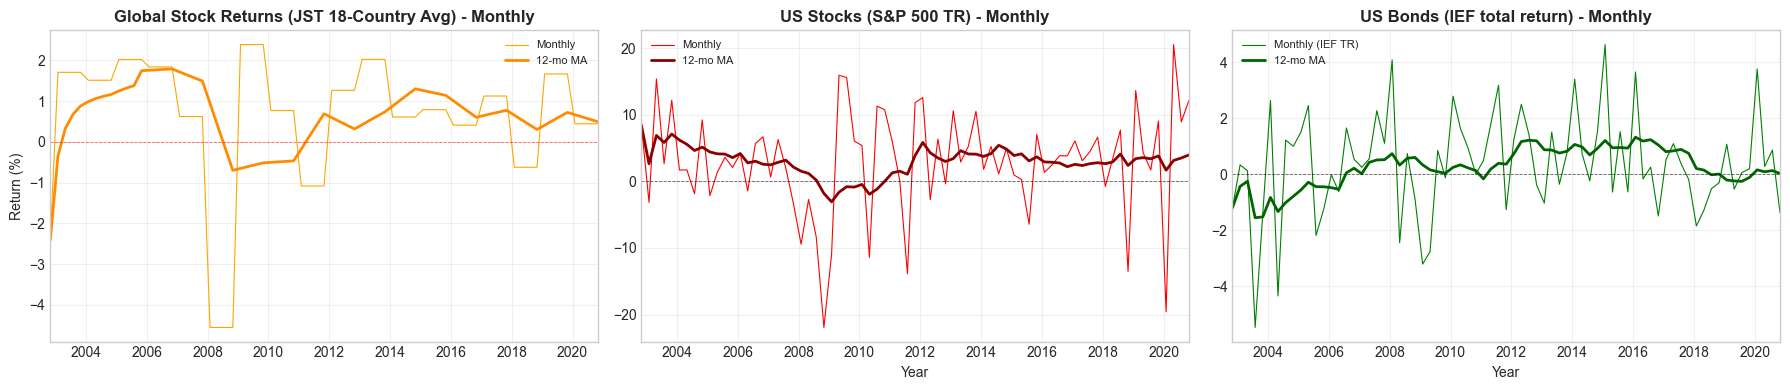

In [34]:
# Visualize Global Stocks, US Stocks, and US Bonds series side-by-side (aligned to `returns_df` timeline)
import matplotlib.pyplot as plt

# Prepare rolling means for smoothing (12-month) using aligned data
global_rm = returns_df['Global_Stocks'].rolling(window=12, min_periods=1).mean() * 100
us_stock_rm = returns_df['US_Stocks'].rolling(window=12, min_periods=1).mean() * 100
us_bond_rm = returns_df['US_Bonds'].rolling(window=12, min_periods=1).mean() * 100

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)

# Global Stocks
axes[0].plot(returns_df.index, returns_df['Global_Stocks'] * 100, color='orange', lw=0.8, label='Monthly')
axes[0].plot(global_rm.index, global_rm, color='darkorange', lw=2, label='12-mo MA')
axes[0].set_title('Global Stock Returns (JST 18-Country Avg) - Monthly', fontweight='bold')
axes[0].set_ylabel('Return (%)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='red', linestyle='--', linewidth=0.6, alpha=0.6)
axes[0].legend(fontsize=8)

# US Stocks
axes[1].plot(returns_df.index, returns_df['US_Stocks'] * 100, color='red', lw=0.8, label='Monthly')
axes[1].plot(us_stock_rm.index, us_stock_rm, color='darkred', lw=2, label='12-mo MA')
axes[1].set_title('US Stocks (S&P 500 TR) - Monthly', fontweight='bold')
axes[1].set_xlabel('Year')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='black', linestyle='--', linewidth=0.6, alpha=0.6)
axes[1].legend(fontsize=8)

# US Bonds (IEF total return)
axes[2].plot(returns_df.index, returns_df['US_Bonds'] * 100, color='green', lw=0.8, label='Monthly (IEF TR)')
axes[2].plot(us_bond_rm.index, us_bond_rm, color='darkgreen', lw=2, label='12-mo MA')
axes[2].set_title('US Bonds (IEF total return) - Monthly', fontweight='bold')
axes[2].set_xlabel('Year')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(0, color='black', linestyle='--', linewidth=0.6, alpha=0.6)
axes[2].legend(fontsize=8)

# Match x-axis timeline across all subplots
start_date, end_date = returns_df.index.min(), returns_df.index.max()
for ax in axes:
    ax.set_xlim(start_date, end_date)

plt.tight_layout()
plt.show()

# Step 4: Align Time Periods and Calculate Portfolio Statistics

Now we'll align all three return series to their common overlapping period and calculate variance-covariance matrix, correlations, and portfolio performance for different asset allocations (60-40, 70-30, 80-20).

In [35]:
print("=" * 80)
print("ALIGNING TIME PERIODS")
print("=" * 80)

# Ensure all are 1D Series
us_stock_returns_clean = us_stock_returns.squeeze() if hasattr(us_stock_returns, 'squeeze') else us_stock_returns
us_bond_returns_clean = us_bond_returns.squeeze() if hasattr(us_bond_returns, 'squeeze') else us_bond_returns
global_stock_returns_clean = global_stock_returns.squeeze() if hasattr(global_stock_returns, 'squeeze') else global_stock_returns

# Normalize indices to end of month
us_stock_returns_clean.index = pd.DatetimeIndex(us_stock_returns_clean.index).to_period('M').to_timestamp('M')
us_bond_returns_clean.index = pd.DatetimeIndex(us_bond_returns_clean.index).to_period('M').to_timestamp('M')
global_stock_returns_clean.index = pd.DatetimeIndex(global_stock_returns_clean.index).to_period('M').to_timestamp('M')

# Drop duplicate timestamps (keep last)
us_stock_returns_clean = us_stock_returns_clean[~us_stock_returns_clean.index.duplicated(keep='last')]
us_bond_returns_clean = us_bond_returns_clean[~us_bond_returns_clean.index.duplicated(keep='last')]
global_stock_returns_clean = global_stock_returns_clean[~global_stock_returns_clean.index.duplicated(keep='last')]

# Align all series to the common overlapping window
returns_df = pd.concat([
    us_stock_returns_clean.rename('US_Stocks'),
    us_bond_returns_clean.rename('US_Bonds'),
    global_stock_returns_clean.rename('Global_Stocks')
], axis=1).dropna()

print(f"\nTime period for each series:")
print(f"  US Stocks:     {us_stock_returns_clean.index.min().strftime('%Y-%m')} to {us_stock_returns_clean.index.max().strftime('%Y-%m')} ({len(us_stock_returns_clean)} months)")
print(f"  US Bonds:      {us_bond_returns_clean.index.min().strftime('%Y-%m')} to {us_bond_returns_clean.index.max().strftime('%Y-%m')} ({len(us_bond_returns_clean)} months)")
print(f"  Global Stocks: {global_stock_returns_clean.index.min().strftime('%Y-%m')} to {global_stock_returns_clean.index.max().strftime('%Y-%m')} ({len(global_stock_returns_clean)} months)")

print(f"\nOverlapping dates: {len(returns_df)} months")
if len(returns_df) > 0:
    print(f"  From {returns_df.index.min().strftime('%Y-%m')} to {returns_df.index.max().strftime('%Y-%m')}")

    print(f"\nFirst few rows:")
    print(returns_df.head())
    print(f"\nLast few rows:")
    print(returns_df.tail())
    print(f"\nSummary statistics:")
    print(returns_df.describe())
else:
    print("  ERROR: No overlapping dates found!")

ALIGNING TIME PERIODS

Time period for each series:
  US Stocks:     1988-04 to 2026-01 (152 months)
  US Bonds:      2002-09 to 2026-01 (281 months)
  Global Stocks: 1870-01 to 2020-12 (1812 months)

Overlapping dates: 73 months
  From 2002-10 to 2020-10

First few rows:
            US_Stocks  US_Bonds  Global_Stocks
2002-10-31   0.084382 -0.012031      -0.024087
2003-01-31  -0.031494  0.003332       0.017076
2003-04-30   0.153931  0.001257       0.017076
2003-07-31   0.026457 -0.054738       0.017076
2003-10-31   0.121768 -0.013933       0.017076

Last few rows:
            US_Stocks  US_Bonds  Global_Stocks
2019-10-31   0.090700  0.002026       0.016687
2020-01-31  -0.195980  0.037611       0.004445
2020-04-30   0.205433  0.002761       0.004445
2020-07-31   0.089293  0.008640       0.004445
2020-10-31   0.121483 -0.013733       0.004445

Summary statistics:
       US_Stocks   US_Bonds  Global_Stocks
count  73.000000  73.000000      73.000000
mean    0.029504   0.003476       0.0067

In [36]:
# Calculate variance-covariance matrix and correlations
print("=" * 80)
print("VARIANCE-COVARIANCE MATRIX AND CORRELATIONS")
print("=" * 80)

# Monthly statistics
mean_returns = returns_df.mean()
std_devs = returns_df.std()
cov_matrix = returns_df.cov()
corr_matrix = returns_df.corr()

print("\nMonthly Mean Returns:")
for asset in returns_df.columns:
    print(f"  {asset:15s}: {mean_returns[asset]:.6f} ({mean_returns[asset]*100:.4f}%)")

print("\nMonthly Standard Deviations:")
for asset in returns_df.columns:
    print(f"  {asset:15s}: {std_devs[asset]:.6f} ({std_devs[asset]*100:.4f}%)")

print("\nAnnualized Statistics (approx):")
for asset in returns_df.columns:
    ann_return = mean_returns[asset] * 12
    ann_std = std_devs[asset] * np.sqrt(12)
    sharpe = ann_return / ann_std if ann_std > 0 else 0
    print(f"  {asset:15s}: Return={ann_return*100:6.2f}%, Std Dev={ann_std*100:6.2f}%, Sharpe={sharpe:.4f}")

print("\nCorrelation Matrix:")
print(corr_matrix)

print("\nCovariance Matrix (monthly):")
print(cov_matrix)

VARIANCE-COVARIANCE MATRIX AND CORRELATIONS

Monthly Mean Returns:
  US_Stocks      : 0.029504 (2.9504%)
  US_Bonds       : 0.003476 (0.3476%)
  Global_Stocks  : 0.006769 (0.6769%)

Monthly Standard Deviations:
  US_Stocks      : 0.079238 (7.9238%)
  US_Bonds       : 0.018304 (1.8304%)
  Global_Stocks  : 0.015966 (1.5966%)

Annualized Statistics (approx):
  US_Stocks      : Return= 35.41%, Std Dev= 27.45%, Sharpe=1.2899
  US_Bonds       : Return=  4.17%, Std Dev=  6.34%, Sharpe=0.6579
  Global_Stocks  : Return=  8.12%, Std Dev=  5.53%, Sharpe=1.4685

Correlation Matrix:
               US_Stocks  US_Bonds  Global_Stocks
US_Stocks       1.000000 -0.193358       0.415721
US_Bonds       -0.193358  1.000000      -0.068367
Global_Stocks   0.415721 -0.068367       1.000000

Covariance Matrix (monthly):
               US_Stocks  US_Bonds  Global_Stocks
US_Stocks       0.006279 -0.000280       0.000526
US_Bonds       -0.000280  0.000335      -0.000020
Global_Stocks   0.000526 -0.000020       0.

In [37]:
# Calculate performance for different US stock/bond allocations
print("=" * 80)
print("PORTFOLIO PERFORMANCE: US STOCKS & BONDS")
print("=" * 80)

# Define allocations (stock weight, bond weight)
allocations = [
    (0.60, 0.40, "60-40"),
    (0.70, 0.30, "70-30"),
    (0.80, 0.20, "80-20")
]

window_start = returns_df.index.min().strftime('%Y-%m')
window_end = returns_df.index.max().strftime('%Y-%m')
print(f"\nPortfolio Performance ({window_start} to {window_end}):")
print("=" * 80)
print(f"{'Portfolio':<12} {'Weight Stock':>12} {'Weight Bond':>12} {'Mean (Mo.)':>12} {'Std (Mo.)':>12} {'Ann. Return':>12} {'Ann. Std':>12} {'Sharpe':>10}")
print("=" * 80)

for stock_w, bond_w, name in allocations:
    # Portfolio returns
    portfolio_returns = stock_w * returns_df['US_Stocks'] + bond_w * returns_df['US_Bonds']
    
    # Monthly statistics
    port_mean = portfolio_returns.mean()
    port_std = portfolio_returns.std()
    
    # Annualized statistics
    ann_return = port_mean * 12
    ann_std = port_std * np.sqrt(12)
    sharpe = ann_return / ann_std if ann_std > 0 else 0
    
    print(f"{name:<12} {stock_w:>12.0%} {bond_w:>12.0%} {port_mean:>12.6f} {port_std:>12.6f} {ann_return:>11.2%} {ann_std:>11.2%} {sharpe:>10.4f}")

print("=" * 80)

# Calculate using portfolio formula
print("\nVerification using portfolio variance formula:")
print("Portfolio variance = w1²σ1² + w2²σ2² + 2w1w2σ1σ2ρ")
print()

for stock_w, bond_w, name in allocations:
    # Get parameters
    mu1 = mean_returns['US_Stocks']
    mu2 = mean_returns['US_Bonds']
    sigma1 = std_devs['US_Stocks']
    sigma2 = std_devs['US_Bonds']
    rho = corr_matrix.loc['US_Stocks', 'US_Bonds']
    
    # Portfolio mean
    port_mean = stock_w * mu1 + bond_w * mu2
    
    # Portfolio variance
    port_var = (stock_w**2 * sigma1**2 + 
                bond_w**2 * sigma2**2 + 
                2 * stock_w * bond_w * sigma1 * sigma2 * rho)
    port_std = np.sqrt(port_var)
    
    # Annualized
    ann_return = port_mean * 12
    ann_std = port_std * np.sqrt(12)
    sharpe = ann_return / ann_std
    
    print(f"{name}: Mean={port_mean:.6f}, Std={port_std:.6f}, Ann.Return={ann_return:.4%}, Ann.Std={ann_std:.4%}, Sharpe={sharpe:.4f}")

PORTFOLIO PERFORMANCE: US STOCKS & BONDS

Portfolio Performance (2002-10 to 2020-10):
Portfolio    Weight Stock  Weight Bond   Mean (Mo.)    Std (Mo.)  Ann. Return     Ann. Std     Sharpe
60-40                 60%          40%     0.019093     0.046683      22.91%      16.17%     1.4168
70-30                 70%          30%     0.021696     0.054671      26.04%      18.94%     1.3747
80-20                 80%          20%     0.024299     0.062785      29.16%      21.75%     1.3407

Verification using portfolio variance formula:
Portfolio variance = w1²σ1² + w2²σ2² + 2w1w2σ1σ2ρ

60-40: Mean=0.019093, Std=0.046683, Ann.Return=22.9119%, Ann.Std=16.1715%, Sharpe=1.4168
70-30: Mean=0.021696, Std=0.054671, Ann.Return=26.0353%, Ann.Std=18.9385%, Sharpe=1.3747
80-20: Mean=0.024299, Std=0.062785, Ann.Return=29.1586%, Ann.Std=21.7494%, Sharpe=1.3407


# Step 5: Find Tangency Portfolios (Maximum Sharpe Ratio)

Now we'll optimize portfolios to find the tangency portfolio - the portfolio with the highest Sharpe ratio. We'll do this for:
1. **2-asset portfolio**: US Stocks + US Bonds
2. **3-asset portfolio**: US Stocks + US Bonds + Global Stocks

In [38]:
from scipy.optimize import minimize
import numpy as np

print("=" * 80)
print("2-ASSET TANGENCY PORTFOLIO: US STOCKS + US BONDS")
print("=" * 80)

# Risk-free rate from T-bill series (separate from risky assets)
rf_series = (tbill_monthly_yield / 12.0).reindex(returns_df.index).dropna()
rf_monthly = rf_series.mean()
print(f"Risk-free (T-bill) monthly mean: {rf_monthly:.6f} ({rf_monthly*100:.4f}%)")

# Extract 2-asset data
mu_2asset = mean_returns[['US_Stocks', 'US_Bonds']].values
cov_2asset = cov_matrix.loc[['US_Stocks', 'US_Bonds'], ['US_Stocks', 'US_Bonds']].values
mu_excess_2 = mu_2asset - rf_monthly

# Analytical (unconstrained) tangency portfolio
cov_inv = np.linalg.inv(cov_2asset)
ones = np.ones(len(mu_2asset))
weights_tangency_2 = cov_inv @ mu_excess_2 / (ones @ cov_inv @ mu_excess_2)

print("\nAnalytical Solution (unconstrained):")
print(f"  US Stocks weight:  {weights_tangency_2[0]:.6f} ({weights_tangency_2[0]*100:.2f}%)")
print(f"  US Bonds weight:   {weights_tangency_2[1]:.6f} ({weights_tangency_2[1]*100:.2f}%)")

# Calculate tangency portfolio performance
port_mean_2 = weights_tangency_2 @ mu_2asset
port_var_2 = weights_tangency_2 @ cov_2asset @ weights_tangency_2
port_std_2 = np.sqrt(port_var_2)
ann_return_2 = port_mean_2 * 12
ann_std_2 = port_std_2 * np.sqrt(12)
sharpe_2 = ((port_mean_2 - rf_monthly) * 12) / (port_std_2 * np.sqrt(12)) if port_std_2 > 0 else 0

print(f"\nTangency Portfolio Performance (unconstrained):")
print(f"  Monthly Mean:      {port_mean_2:.6f} ({port_mean_2*100:.4f}%)")
print(f"  Monthly Std Dev:   {port_std_2:.6f} ({port_std_2*100:.4f}%)")
print(f"  Annual Return:     {ann_return_2:.4%}")
print(f"  Annual Std Dev:    {ann_std_2:.4%}")
print(f"  Sharpe Ratio:      {sharpe_2:.6f}")

# Verify with constrained optimization (no shorting)
def negative_sharpe_2asset(weights):
    port_return = weights @ mu_2asset
    port_std = np.sqrt(weights @ cov_2asset @ weights)
    excess = port_return - rf_monthly
    return -(excess / port_std) if port_std > 0 else 1e10

# Constraints: weights sum to 1
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0, 1) for _ in range(2)]  # No short selling
initial_guess = [0.5, 0.5]

result_2 = minimize(negative_sharpe_2asset, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# Consistent Sharpe calculation (annualized)
opt_mean_2 = result_2.x @ mu_2asset
opt_std_2 = np.sqrt(result_2.x @ cov_2asset @ result_2.x)
opt_sharpe_2 = ((opt_mean_2 - rf_monthly) * 12) / (opt_std_2 * np.sqrt(12)) if opt_std_2 > 0 else 0

print(f"\nOptimization Verification (no shorting):")
print(f"  US Stocks weight:  {result_2.x[0]:.6f} ({result_2.x[0]*100:.2f}%)")
print(f"  US Bonds weight:   {result_2.x[1]:.6f} ({result_2.x[1]*100:.2f}%)")
print(f"  Sharpe Ratio:      {opt_sharpe_2:.6f}")

2-ASSET TANGENCY PORTFOLIO: US STOCKS + US BONDS
Risk-free (T-bill) monthly mean: 0.001035 (0.1035%)

Analytical Solution (unconstrained):
  US Stocks weight:  0.304847 (30.48%)
  US Bonds weight:   0.695153 (69.52%)

Tangency Portfolio Performance (unconstrained):
  Monthly Mean:      0.011411 (1.1411%)
  Monthly Std Dev:   0.025030 (2.5030%)
  Annual Return:     13.6932%
  Annual Std Dev:    8.6708%
  Sharpe Ratio:      1.435957

Optimization Verification (no shorting):
  US Stocks weight:  0.304885 (30.49%)
  US Bonds weight:   0.695115 (69.51%)
  Sharpe Ratio:      1.435957


In [39]:
print("\n" + "=" * 80)
print("3-ASSET TANGENCY PORTFOLIO: US STOCKS + US BONDS + GLOBAL STOCKS")
print("=" * 80)

# Risk-free rate from T-bill series (separate from risky assets)
rf_series = (tbill_monthly_yield / 12.0).reindex(returns_df.index).dropna()
rf_monthly = rf_series.mean()
print(f"Risk-free (T-bill) monthly mean: {rf_monthly:.6f} ({rf_monthly*100:.4f}%)")

# Extract 3-asset data
mu_3asset = mean_returns.values
cov_3asset = cov_matrix.values
mu_excess_3 = mu_3asset - rf_monthly

# Analytical (unconstrained) tangency portfolio
cov_inv_3 = np.linalg.inv(cov_3asset)
ones_3 = np.ones(len(mu_3asset))
weights_tangency_3 = cov_inv_3 @ mu_excess_3 / (ones_3 @ cov_inv_3 @ mu_excess_3)

print("\nAnalytical Solution (unconstrained):")
for i, asset in enumerate(returns_df.columns):
    print(f"  {asset:15s} weight: {weights_tangency_3[i]:8.6f} ({weights_tangency_3[i]*100:6.2f}%)")

# Calculate tangency portfolio performance
port_mean_3 = weights_tangency_3 @ mu_3asset
port_var_3 = weights_tangency_3 @ cov_3asset @ weights_tangency_3
port_std_3 = np.sqrt(port_var_3)
ann_return_3 = port_mean_3 * 12
ann_std_3 = port_std_3 * np.sqrt(12)
sharpe_3 = ((port_mean_3 - rf_monthly) * 12) / (port_std_3 * np.sqrt(12)) if port_std_3 > 0 else 0

print(f"\nTangency Portfolio Performance (unconstrained):")
print(f"  Monthly Mean:      {port_mean_3:.6f} ({port_mean_3*100:.4f}%)")
print(f"  Monthly Std Dev:   {port_std_3:.6f} ({port_std_3*100:.4f}%)")
print(f"  Annual Return:     {ann_return_3:.4%}")
print(f"  Annual Std Dev:    {ann_std_3:.4%}")
print(f"  Sharpe Ratio:      {sharpe_3:.6f}")

# Verify with constrained optimization (no shorting)
def negative_sharpe_3asset(weights):
    port_return = weights @ mu_3asset
    port_std = np.sqrt(weights @ cov_3asset @ weights)
    excess = port_return - rf_monthly
    return -(excess / port_std) if port_std > 0 else 1e10

# Constraints: weights sum to 1
constraints_3 = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds_3 = [(0, 1) for _ in range(3)]  # No short selling
initial_guess_3 = [1/3, 1/3, 1/3]

result_3 = minimize(negative_sharpe_3asset, initial_guess_3, method='SLSQP', bounds=bounds_3, constraints=constraints_3)

# Consistent Sharpe calculation (annualized)
opt_mean_3 = result_3.x @ mu_3asset
opt_std_3 = np.sqrt(result_3.x @ cov_3asset @ result_3.x)
opt_sharpe_3 = ((opt_mean_3 - rf_monthly) * 12) / (opt_std_3 * np.sqrt(12)) if opt_std_3 > 0 else 0

print(f"\nOptimization Verification (no shorting):")
for i, asset in enumerate(returns_df.columns):
    print(f"  {asset:15s} weight: {result_3.x[i]:8.6f} ({result_3.x[i]*100:6.2f}%)")
print(f"  Sharpe Ratio:      {opt_sharpe_3:.6f}")

# Compare all tangency portfolios
print("\n" + "=" * 80)
print("SUMMARY: TANGENCY PORTFOLIO COMPARISON")
print("=" * 80)
print(f"{'Portfolio':<20} {'Ann. Return':>12} {'Ann. Std Dev':>12} {'Sharpe Ratio':>12}")
print("=" * 80)
print(f"{'2-Asset (US only)':<20} {ann_return_2:>11.2%} {ann_std_2:>11.2%} {sharpe_2:>12.4f}")
print(f"{'3-Asset (+ Global)':<20} {ann_return_3:>11.2%} {ann_std_3:>11.2%} {sharpe_3:>12.4f}")
print("=" * 80)


3-ASSET TANGENCY PORTFOLIO: US STOCKS + US BONDS + GLOBAL STOCKS
Risk-free (T-bill) monthly mean: 0.001035 (0.1035%)

Analytical Solution (unconstrained):
  US_Stocks       weight: 0.121154 ( 12.12%)
  US_Bonds        weight: 0.368725 ( 36.87%)
  Global_Stocks   weight: 0.510121 ( 51.01%)

Tangency Portfolio Performance (unconstrained):
  Monthly Mean:      0.008309 (0.8309%)
  Monthly Std Dev:   0.015378 (1.5378%)
  Annual Return:     9.9710%
  Annual Std Dev:    5.3271%
  Sharpe Ratio:      1.638547

Optimization Verification (no shorting):
  US_Stocks       weight: 0.121008 ( 12.10%)
  US_Bonds        weight: 0.368509 ( 36.85%)
  Global_Stocks   weight: 0.510483 ( 51.05%)
  Sharpe Ratio:      1.638546

SUMMARY: TANGENCY PORTFOLIO COMPARISON
Portfolio             Ann. Return Ann. Std Dev Sharpe Ratio
2-Asset (US only)         13.69%       8.67%       1.4360
3-Asset (+ Global)         9.97%       5.33%       1.6385


Generating efficient frontier plots...
  Computing 2-asset efficient frontier...
  Computing 3-asset efficient frontier...


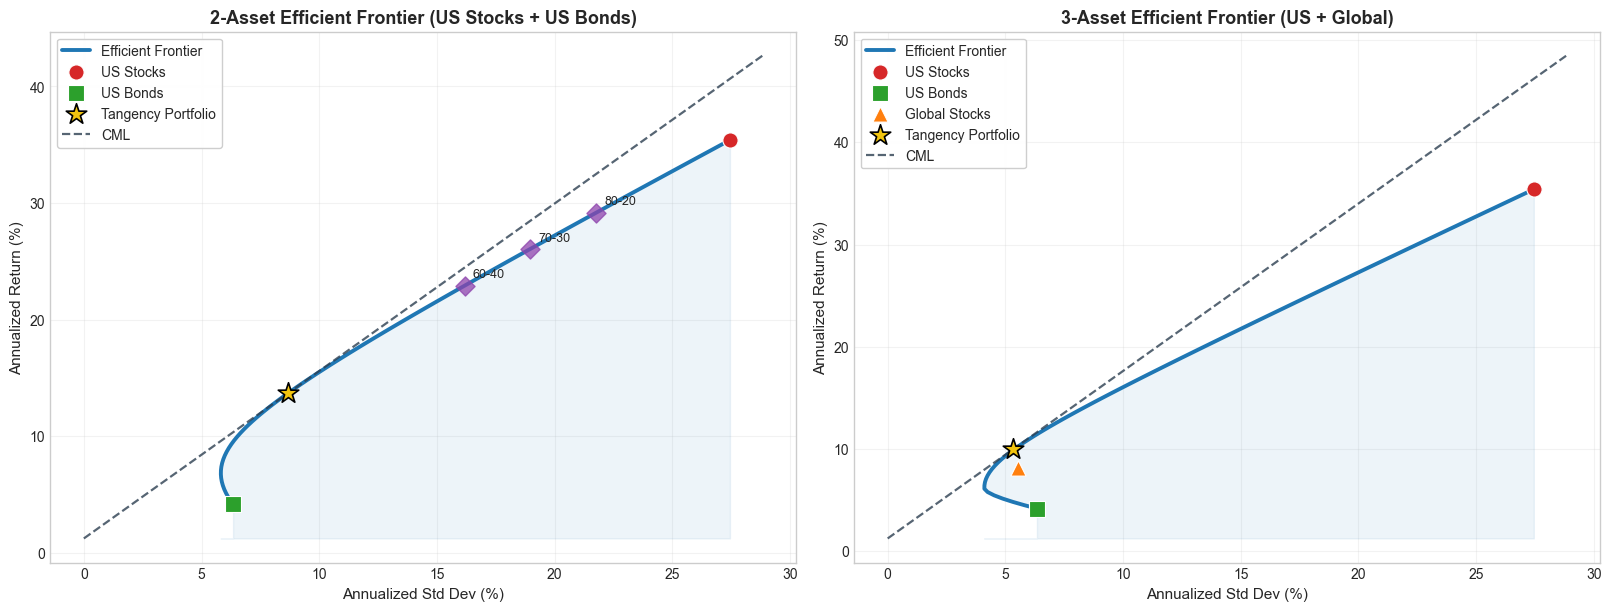


✓ Efficient frontier plots generated


In [40]:
# Generate efficient frontier visualizations
import matplotlib.pyplot as plt

print("Generating efficient frontier plots...")

# Function to generate efficient frontier
def generate_efficient_frontier(mu, cov, n_points=100):
    """Generate efficient frontier by varying target returns"""
    n_assets = len(mu)
    
    # Range of target returns
    min_return = np.min(mu)
    max_return = np.max(mu)
    target_returns = np.linspace(min_return, max_return * 1.2, n_points)
    
    frontier_stds = []
    frontier_returns = []
    frontier_weights = []
    
    for target in target_returns:
        # Minimize variance subject to target return
        def portfolio_variance(weights):
            return weights @ cov @ weights
        
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # weights sum to 1
            {'type': 'eq', 'fun': lambda w: w @ mu - target}  # achieve target return
        ]
        bounds = [(0, 1) for _ in range(n_assets)]
        
        result = minimize(portfolio_variance, np.ones(n_assets)/n_assets, 
                         method='SLSQP', bounds=bounds, constraints=constraints)
        
        if result.success:
            port_std = np.sqrt(result.fun)
            frontier_stds.append(port_std)
            frontier_returns.append(target)
            frontier_weights.append(result.x)
    
    return np.array(frontier_returns), np.array(frontier_stds), frontier_weights

# Generate frontiers
print("  Computing 2-asset efficient frontier...")
ef_returns_2, ef_stds_2, ef_weights_2 = generate_efficient_frontier(mu_2asset, cov_2asset, n_points=120)

print("  Computing 3-asset efficient frontier...")
ef_returns_3, ef_stds_3, ef_weights_3 = generate_efficient_frontier(mu_3asset, cov_3asset, n_points=120)

# Annualize for plotting
ef_returns_2_ann = ef_returns_2 * 12 * 100
ef_stds_2_ann = ef_stds_2 * np.sqrt(12) * 100
ef_returns_3_ann = ef_returns_3 * 12 * 100
ef_stds_3_ann = ef_stds_3 * np.sqrt(12) * 100

# Risk-free rate (annualized) for CML
rf_series = (tbill_monthly_yield / 12.0).reindex(returns_df.index).dropna()
rf_monthly = rf_series.mean()
rf_ann = rf_monthly * 12 * 100

# Styling
plt.style.use("seaborn-v0_8-whitegrid")
frontier_color = "#1f77b4"
stock_color = "#d62728"
bond_color = "#2ca02c"
global_color = "#ff7f0e"
tangency_color = "#f1c40f"
alloc_color = "#8e44ad"
cml_color = "#2c3e50"

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

# Plot 1: 2-Asset Efficient Frontier
ax1.plot(ef_stds_2_ann, ef_returns_2_ann, color=frontier_color, linewidth=2.8, label='Efficient Frontier')
ax1.fill_between(ef_stds_2_ann, ef_returns_2_ann, rf_ann, color=frontier_color, alpha=0.08)
ax1.scatter(std_devs['US_Stocks']*np.sqrt(12)*100, mean_returns['US_Stocks']*12*100, 
           s=120, c=stock_color, marker='o', edgecolors='white', linewidths=0.8, label='US Stocks', zorder=5)
ax1.scatter(std_devs['US_Bonds']*np.sqrt(12)*100, mean_returns['US_Bonds']*12*100, 
           s=120, c=bond_color, marker='s', edgecolors='white', linewidths=0.8, label='US Bonds', zorder=5)
ax1.scatter(ann_std_2*100, ann_return_2*100, s=240, c=tangency_color, marker='*', 
           edgecolors='black', linewidths=1.2, label='Tangency Portfolio', zorder=6)

# Capital Market Line (2-asset tangency)
cml_x = np.linspace(0, ef_stds_2_ann.max()*1.05, 100)
cml_y = rf_ann + (ann_return_2*100 - rf_ann) / (ann_std_2*100) * cml_x
ax1.plot(cml_x, cml_y, linestyle='--', color=cml_color, linewidth=1.6, alpha=0.8, label='CML')

# Add 60-40, 70-30, 80-20
for stock_w, bond_w, name in [(0.60, 0.40, "60-40"), (0.70, 0.30, "70-30"), (0.80, 0.20, "80-20")]:
    port_ret = (stock_w * mean_returns['US_Stocks'] + bond_w * mean_returns['US_Bonds']) * 12 * 100
    port_std = np.sqrt(stock_w**2 * std_devs['US_Stocks']**2 + 
                       bond_w**2 * std_devs['US_Bonds']**2 + 
                       2*stock_w*bond_w*std_devs['US_Stocks']*std_devs['US_Bonds']*corr_matrix.loc['US_Stocks','US_Bonds']) * np.sqrt(12) * 100
    ax1.scatter(port_std, port_ret, s=95, c=alloc_color, marker='D', alpha=0.75, zorder=4)
    ax1.annotate(name, (port_std, port_ret), xytext=(6, 6), textcoords='offset points', fontsize=9)

ax1.set_xlabel('Annualized Std Dev (%)', fontsize=11)
ax1.set_ylabel('Annualized Return (%)', fontsize=11)
ax1.set_title('2-Asset Efficient Frontier (US Stocks + US Bonds)', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', frameon=True, framealpha=0.95)
ax1.grid(True, alpha=0.25)

# Plot 2: 3-Asset Efficient Frontier
ax2.plot(ef_stds_3_ann, ef_returns_3_ann, color=frontier_color, linewidth=2.8, label='Efficient Frontier')
ax2.fill_between(ef_stds_3_ann, ef_returns_3_ann, rf_ann, color=frontier_color, alpha=0.08)
ax2.scatter(std_devs['US_Stocks']*np.sqrt(12)*100, mean_returns['US_Stocks']*12*100, 
           s=120, c=stock_color, marker='o', edgecolors='white', linewidths=0.8, label='US Stocks', zorder=5)
ax2.scatter(std_devs['US_Bonds']*np.sqrt(12)*100, mean_returns['US_Bonds']*12*100, 
           s=120, c=bond_color, marker='s', edgecolors='white', linewidths=0.8, label='US Bonds', zorder=5)
ax2.scatter(std_devs['Global_Stocks']*np.sqrt(12)*100, mean_returns['Global_Stocks']*12*100, 
           s=120, c=global_color, marker='^', edgecolors='white', linewidths=0.8, label='Global Stocks', zorder=5)
ax2.scatter(ann_std_3*100, ann_return_3*100, s=240, c=tangency_color, marker='*', 
           edgecolors='black', linewidths=1.2, label='Tangency Portfolio', zorder=6)

# Capital Market Line (3-asset tangency)
cml_x3 = np.linspace(0, ef_stds_3_ann.max()*1.05, 100)
cml_y3 = rf_ann + (ann_return_3*100 - rf_ann) / (ann_std_3*100) * cml_x3
ax2.plot(cml_x3, cml_y3, linestyle='--', color=cml_color, linewidth=1.6, alpha=0.8, label='CML')

ax2.set_xlabel('Annualized Std Dev (%)', fontsize=11)
ax2.set_ylabel('Annualized Return (%)', fontsize=11)
ax2.set_title('3-Asset Efficient Frontier (US + Global)', fontsize=13, fontweight='bold')
ax2.legend(loc='upper left', frameon=True, framealpha=0.95)
ax2.grid(True, alpha=0.25)

plt.show()

print("\n✓ Efficient frontier plots generated")


ADVANCED VISUALIZATIONS: PREMIUM ANALYSIS SUITE


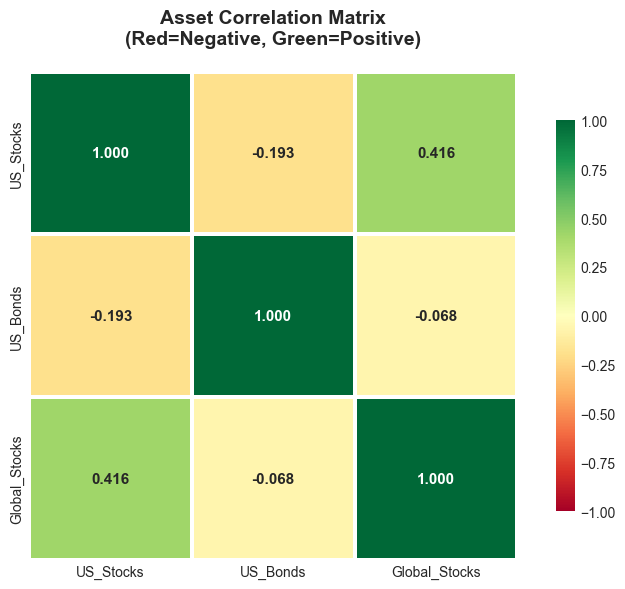

✓ Correlation heatmap rendered


In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n" + "="*80)
print("ADVANCED VISUALIZATIONS: PREMIUM ANALYSIS SUITE")
print("="*80)

# ============================================================================
# 1. CORRELATION HEATMAP WITH ANNOTATIONS
# ============================================================================
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            square=True, linewidths=1.5, cbar_kws={"shrink": 0.8}, 
            vmin=-1, vmax=1, ax=ax, annot_kws={"fontsize": 11, "weight": "bold"})
ax.set_title('Asset Correlation Matrix\n(Red=Negative, Green=Positive)', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Correlation heatmap rendered")

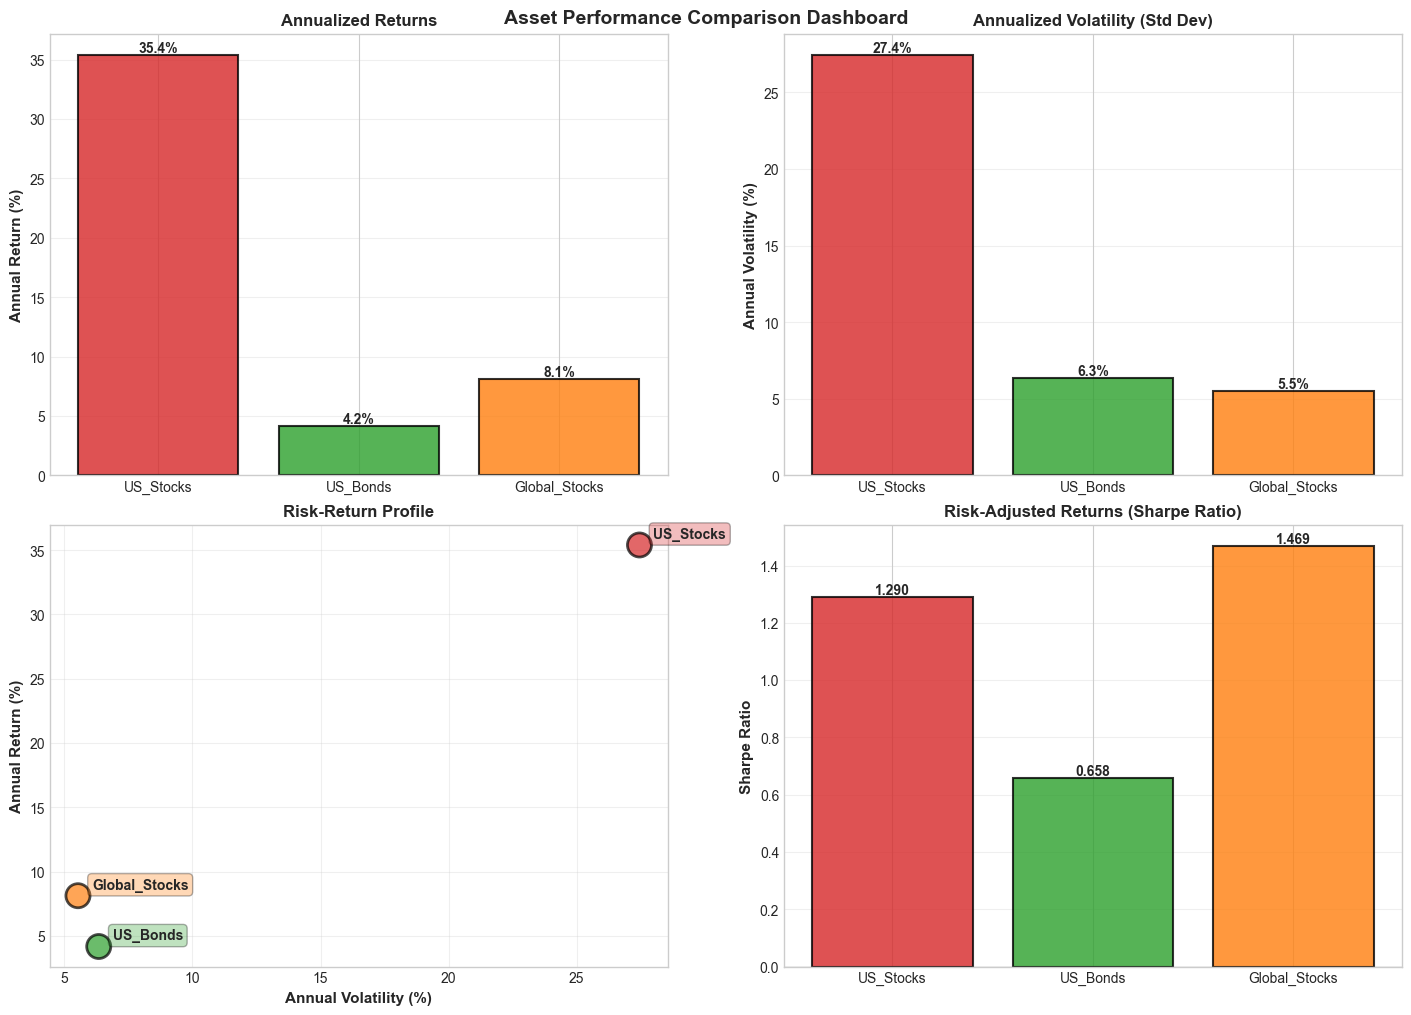

✓ Asset comparison dashboard rendered


In [42]:
# ============================================================================
# 2. ASSET COMPARISON DASHBOARD: RETURNS, VOLATILITY, SHARPE RATIO
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# Compute annualized stats for plotting
asset_names = returns_df.columns.tolist()
ann_returns = [mean_returns[a] * 12 * 100 for a in asset_names]
ann_vols = [std_devs[a] * np.sqrt(12) * 100 for a in asset_names]
sharpe_ratios = [ann_returns[i] / ann_vols[i] for i in range(len(asset_names))]

# Color palette
colors = ['#d62728', '#2ca02c', '#ff7f0e']

# (1) Annual Returns
ax = axes[0, 0]
bars1 = ax.bar(asset_names, ann_returns, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Annual Return (%)', fontsize=11, fontweight='bold')
ax.set_title('Annualized Returns', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{ann_returns[i]:.1f}%', ha='center', va='bottom', fontweight='bold')

# (2) Annual Volatility
ax = axes[0, 1]
bars2 = ax.bar(asset_names, ann_vols, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Annual Volatility (%)', fontsize=11, fontweight='bold')
ax.set_title('Annualized Volatility (Std Dev)', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{ann_vols[i]:.1f}%', ha='center', va='bottom', fontweight='bold')

# (3) Risk-Return Scatter
ax = axes[1, 0]
scatter = ax.scatter(ann_vols, ann_returns, s=300, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
for i, name in enumerate(asset_names):
    ax.annotate(name, (ann_vols[i], ann_returns[i]), xytext=(10, 5), 
                textcoords='offset points', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.3))
ax.set_xlabel('Annual Volatility (%)', fontsize=11, fontweight='bold')
ax.set_ylabel('Annual Return (%)', fontsize=11, fontweight='bold')
ax.set_title('Risk-Return Profile', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# (4) Sharpe Ratios
ax = axes[1, 1]
bars4 = ax.bar(asset_names, sharpe_ratios, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Sharpe Ratio', fontsize=11, fontweight='bold')
ax.set_title('Risk-Adjusted Returns (Sharpe Ratio)', fontsize=12, fontweight='bold')
ax.axhline(0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='y', alpha=0.3)
for i, bar in enumerate(bars4):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{sharpe_ratios[i]:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Asset Performance Comparison Dashboard', fontsize=14, fontweight='bold', y=1.00)
plt.show()

print("✓ Asset comparison dashboard rendered")

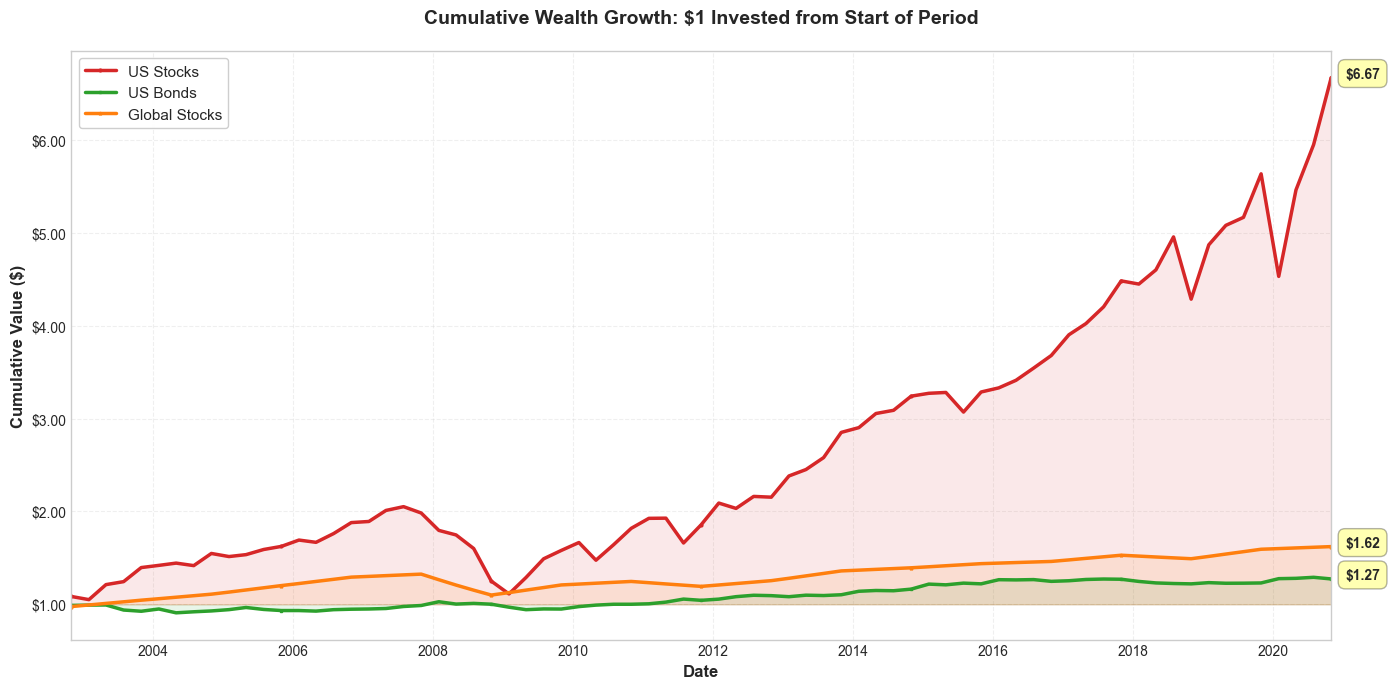

✓ Cumulative wealth growth chart rendered


In [50]:
# ============================================================================
# 3. CUMULATIVE WEALTH GROWTH: $1 INVESTED IN EACH ASSET
# ============================================================================
fig, ax = plt.subplots(figsize=(14, 7))

# Compute cumulative growth (starting with $1)
cumulative_returns = (1 + returns_df).cumprod()

# Plot
ax.plot(cumulative_returns.index, cumulative_returns['US_Stocks'], 
        label='US Stocks', linewidth=2.5, color='#d62728', marker='o', markersize=2, markevery=12)
ax.plot(cumulative_returns.index, cumulative_returns['US_Bonds'], 
        label='US Bonds', linewidth=2.5, color='#2ca02c', marker='s', markersize=2, markevery=12)
ax.plot(cumulative_returns.index, cumulative_returns['Global_Stocks'], 
        label='Global Stocks', linewidth=2.5, color='#ff7f0e', marker='^', markersize=2, markevery=12)

# Fill between for visual effect
ax.fill_between(cumulative_returns.index, 1, cumulative_returns['US_Stocks'], 
                alpha=0.1, color='#d62728')
ax.fill_between(cumulative_returns.index, 1, cumulative_returns['US_Bonds'], 
                alpha=0.1, color='#2ca02c')
ax.fill_between(cumulative_returns.index, 1, cumulative_returns['Global_Stocks'], 
                alpha=0.1, color='#ff7f0e')

ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Value ($)', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Wealth Growth: $1 Invested from Start of Period', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='upper left', frameon=True, fontsize=11, framealpha=0.95)

# Align x-axis to exact data range and format yearly ticks
from matplotlib.dates import YearLocator, DateFormatter
start_date, end_date = cumulative_returns.index.min(), cumulative_returns.index.max()
ax.set_xlim(start_date, end_date)
ax.xaxis.set_major_locator(YearLocator(base=2))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))
ax.tick_params(axis='x', rotation=0)

# Use linear scale to keep plain numeric labels (not scientific notation)
# ax.set_yscale('log')  # switched to linear to avoid scientific formatting on y-axis

# Format y-axis to avoid scientific notation and show plain numbers with commas
from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
mpl.rcParams['axes.formatter.use_mathtext'] = False
ax.ticklabel_format(style='plain', axis='y', useOffset=False)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${x:,.2f}'))

# Add final values
final_vals = cumulative_returns.iloc[-1]
for i, col in enumerate(cumulative_returns.columns):
    ax.annotate(f'${final_vals[col]:.2f}', 
                xy=(cumulative_returns.index[-1], final_vals[col]),
                xytext=(10, 0), textcoords='offset points',
                fontsize=10, fontweight='bold', 
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.show()

print("✓ Cumulative wealth growth chart rendered")

Rolling-Sharpe y-limits set to [-2, 15]


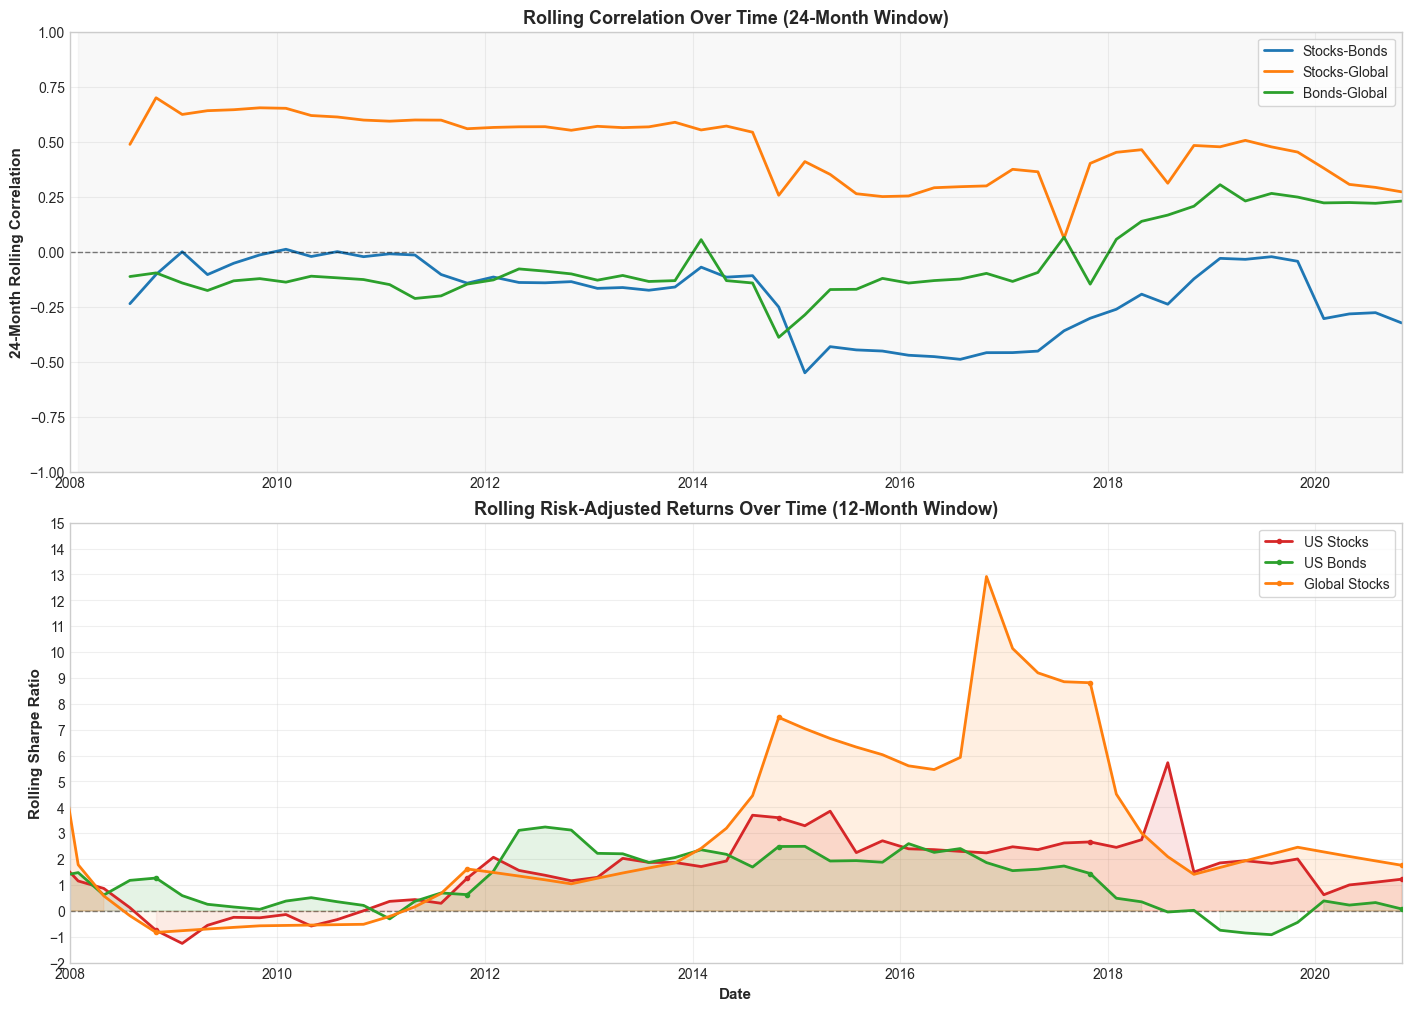

✓ Rolling statistics charts rendered


In [44]:
# ============================================================================
# 4. ROLLING STATISTICS: ROLLING CORRELATION & SHARPE RATIO
# ============================================================================
fig, axes = plt.subplots(2, 1, figsize=(14, 10), constrained_layout=True)

# (1) Rolling 24-month Correlations
rolling_corr_sb = returns_df['US_Stocks'].rolling(24).corr(returns_df['US_Bonds'])
rolling_corr_sg = returns_df['US_Stocks'].rolling(24).corr(returns_df['Global_Stocks'])
rolling_corr_bg = returns_df['US_Bonds'].rolling(24).corr(returns_df['Global_Stocks'])

# Filter start date for correlation plot to 2008-01 for consistency
import pandas as pd
start_date = pd.to_datetime('2008-01-01')
rolling_corr_sb_f = rolling_corr_sb.loc[rolling_corr_sb.index >= start_date]
rolling_corr_sg_f = rolling_corr_sg.loc[rolling_corr_sg.index >= start_date]
rolling_corr_bg_f = rolling_corr_bg.loc[rolling_corr_bg.index >= start_date]

ax = axes[0]
ax.plot(rolling_corr_sb_f.index, rolling_corr_sb_f, label='Stocks-Bonds', linewidth=2, color='#1f77b4')
ax.plot(rolling_corr_sg_f.index, rolling_corr_sg_f, label='Stocks-Global', linewidth=2, color='#ff7f0e')
ax.plot(rolling_corr_bg_f.index, rolling_corr_bg_f, label='Bonds-Global', linewidth=2, color='#2ca02c')
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.fill_between(rolling_corr_sb_f.index, -1, 1, alpha=0.05, color='gray')
ax.set_ylabel('24-Month Rolling Correlation', fontsize=11, fontweight='bold')
ax.set_title('Rolling Correlation Over Time (24-Month Window)', fontsize=13, fontweight='bold')
ax.legend(loc='best', frameon=True, fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim([-1, 1])
ax.set_xlim([start_date, returns_df.index.max()])

# (2) Rolling 12-month Sharpe Ratios
def rolling_sharpe(returns, window=12):
    """Calculate rolling Sharpe ratio"""
    rolling_mean = returns.rolling(window).mean() * 12
    rolling_std = returns.rolling(window).std() * np.sqrt(12)
    return rolling_mean / rolling_std

rolling_sharpe_stocks = rolling_sharpe(returns_df['US_Stocks'], 12)
rolling_sharpe_bonds = rolling_sharpe(returns_df['US_Bonds'], 12)
rolling_sharpe_global = rolling_sharpe(returns_df['Global_Stocks'], 12)

ax2 = axes[1]
# plot lines first (add small markers for clarity)
ax2.plot(rolling_sharpe_stocks.index, rolling_sharpe_stocks, label='US Stocks', 
         linewidth=2.0, color='#d62728', marker='o', markersize=3, markevery=12, zorder=4)
ax2.plot(rolling_sharpe_bonds.index, rolling_sharpe_bonds, label='US Bonds', 
         linewidth=2.0, color='#2ca02c', marker='o', markersize=3, markevery=12, zorder=4)
ax2.plot(rolling_sharpe_global.index, rolling_sharpe_global, label='Global Stocks', 
         linewidth=2.0, color='#ff7f0e', marker='o', markersize=3, markevery=12, zorder=4)
ax2.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=1)

# Fill positive and negative areas separately so up/down is visible (keeps lines visible)
import numpy as np
series_list = [(rolling_sharpe_stocks, '#d62728'), (rolling_sharpe_bonds, '#2ca02c'), (rolling_sharpe_global, '#ff7f0e')]
for series, color in series_list:
    s = series.copy()
    pos = s.clip(lower=0)
    neg = s.clip(upper=0)
    ax2.fill_between(s.index, 0, pos, where=~pos.isna() & (pos > 0), alpha=0.12, color=color, zorder=2)
    ax2.fill_between(s.index, 0, neg, where=~neg.isna() & (neg < 0), alpha=0.06, color=color, zorder=2)

ax2.set_ylabel('Rolling Sharpe Ratio', fontsize=11, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11, fontweight='bold')
ax2.set_title('Rolling Risk-Adjusted Returns Over Time (12-Month Window)', fontsize=13, fontweight='bold')
ax2.legend(loc='best', frameon=True, fontsize=10)
ax2.grid(True, alpha=0.3)

# Set fixed y-limits to [-2, 15] per user request
ax2.set_ylim([-2, 15])
print("Rolling-Sharpe y-limits set to [-2, 15]")

# Force major ticks at 1.0 intervals and minor ticks at 0.5 for clear single-unit ticks
from matplotlib.ticker import MultipleLocator
ax2.yaxis.set_major_locator(MultipleLocator(1.0))
ax2.yaxis.set_minor_locator(MultipleLocator(0.5))

# Align x-limits for both subplots to the same window (start at 2008)
ax2.set_xlim([start_date, returns_df.index.max()])

plt.show()

print("✓ Rolling statistics charts rendered")

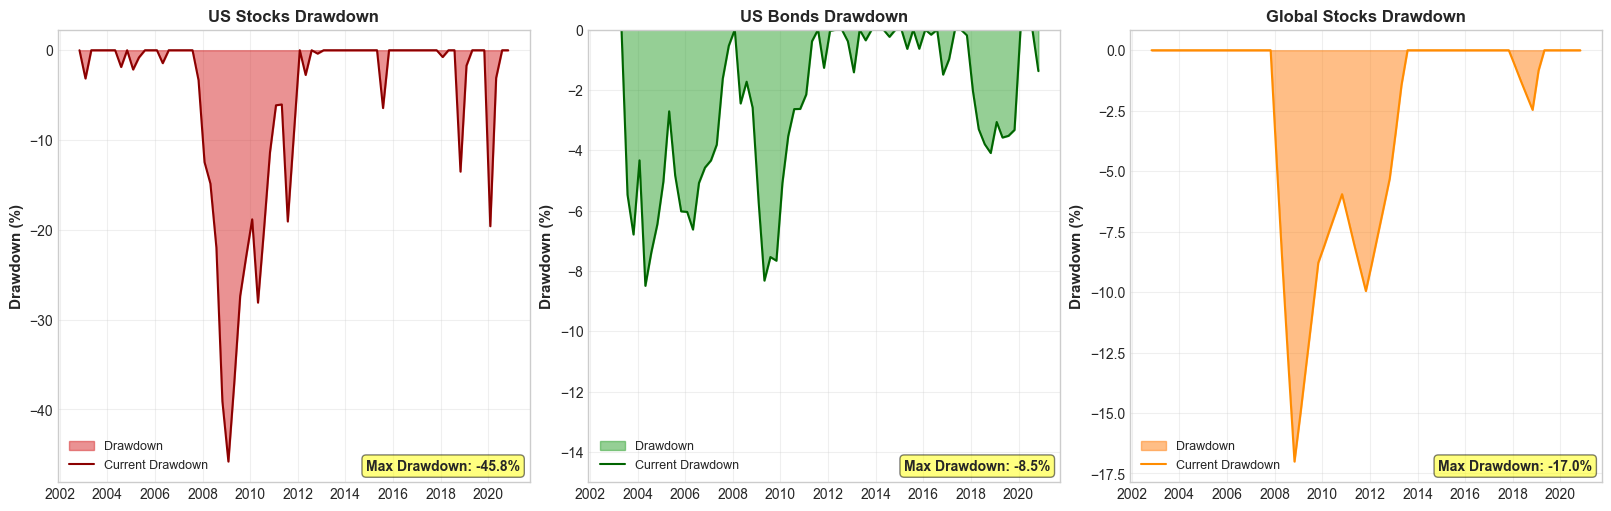

✓ Drawdown charts rendered


In [45]:
# ============================================================================
# 5. DRAWDOWN ANALYSIS: UNDERWATER PLOTS
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

def calculate_drawdown(returns):
    """Calculate running maximum and drawdown"""
    cumul = (1 + returns).cumprod()
    running_max = cumul.expanding().max()
    drawdown = (cumul - running_max) / running_max * 100
    return drawdown

# Calculate drawdowns
dd_stocks = calculate_drawdown(returns_df['US_Stocks'])
dd_bonds = calculate_drawdown(returns_df['US_Bonds'])
dd_global = calculate_drawdown(returns_df['Global_Stocks'])

# Plot (1) US Stocks
ax = axes[0]
ax.fill_between(dd_stocks.index, 0, dd_stocks, alpha=0.5, color='#d62728', label='Drawdown')
ax.plot(dd_stocks.index, dd_stocks, color='darkred', linewidth=1.5, label='Current Drawdown')
ax.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
ax.set_title('US Stocks Drawdown', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
min_dd_s = dd_stocks.min()
ax.text(0.98, 0.02, f'Max Drawdown: {min_dd_s:.1f}%', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5), fontsize=10, fontweight='bold',
        verticalalignment='bottom', horizontalalignment='right')

# Plot (2) US Bonds
ax = axes[1]
ax.fill_between(dd_bonds.index, 0, dd_bonds, alpha=0.5, color='#2ca02c', label='Drawdown')
ax.plot(dd_bonds.index, dd_bonds, color='darkgreen', linewidth=1.5, label='Current Drawdown')
ax.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
ax.set_title('US Bonds Drawdown', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
min_dd_b = dd_bonds.min()
# Place max-drawdown label bottom-right inside the axes
ax.text(0.98, 0.02, f'Max Drawdown: {min_dd_b:.1f}%', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5), fontsize=10, fontweight='bold',
        verticalalignment='bottom', horizontalalignment='right')
# Expand y-axis to -15 to match other plots' visual scale
ax.set_ylim([-15, 0])

# Plot (3) Global Stocks
ax = axes[2]
ax.fill_between(dd_global.index, 0, dd_global, alpha=0.5, color='#ff7f0e', label='Drawdown')
ax.plot(dd_global.index, dd_global, color='darkorange', linewidth=1.5, label='Current Drawdown')
ax.set_ylabel('Drawdown (%)', fontsize=11, fontweight='bold')
ax.set_title('Global Stocks Drawdown', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
min_dd_g = dd_global.min()
ax.text(0.98, 0.02, f'Max Drawdown: {min_dd_g:.1f}%', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5), fontsize=10, fontweight='bold',
        verticalalignment='bottom', horizontalalignment='right')

plt.show()

print("✓ Drawdown charts rendered")

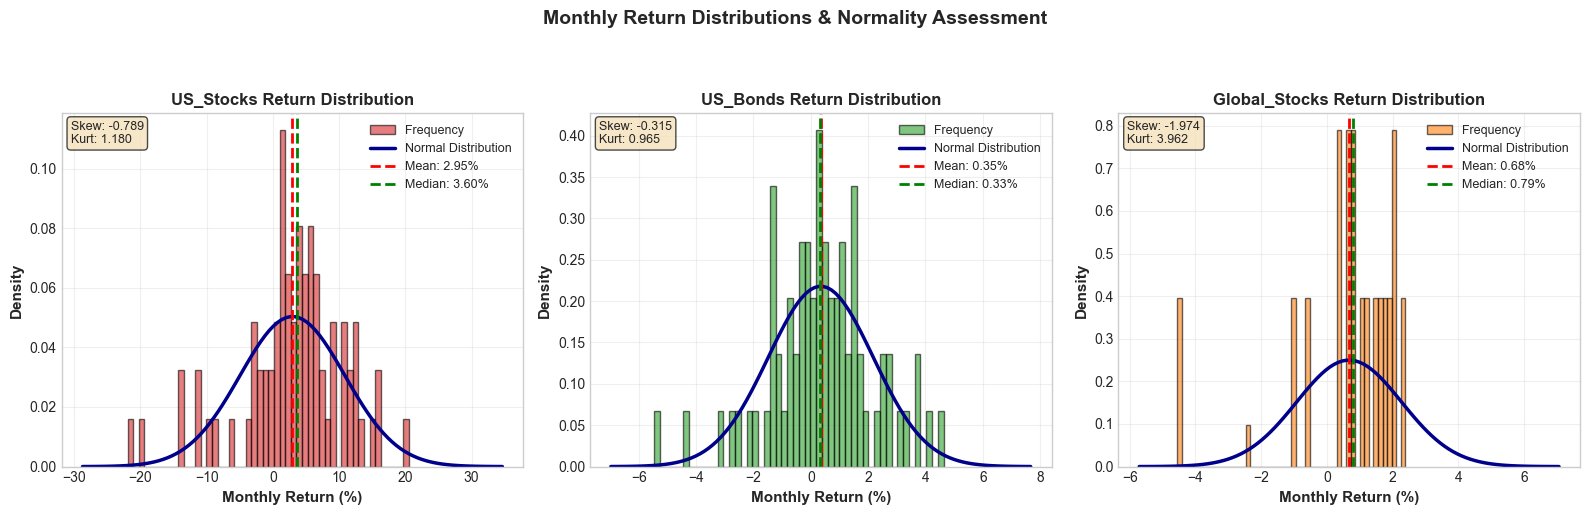

✓ Return distribution analysis rendered


In [46]:
# ============================================================================
# 6. RETURN DISTRIBUTIONS: HISTOGRAMS & STATISTICS
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=False)

colors_hist = ['#d62728', '#2ca02c', '#ff7f0e']
asset_cols = returns_df.columns.tolist()

for idx, (ax, col, color) in enumerate(zip(axes, asset_cols, colors_hist)):
    returns_pct = returns_df[col] * 100
    
    # Histogram with KDE
    ax.hist(returns_pct, bins=50, color=color, alpha=0.6, edgecolor='black', density=True, label='Frequency')
    
    # Add normal distribution overlay
    mu, sigma = returns_pct.mean(), returns_pct.std()
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    from scipy import stats
    ax.plot(x, stats.norm.pdf(x, mu, sigma), color='darkblue', linewidth=2.5, label='Normal Distribution')
    
    # Vertical lines for mean and median
    ax.axvline(mu, color='red', linestyle='--', linewidth=2, label=f'Mean: {mu:.2f}%')
    ax.axvline(returns_pct.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {returns_pct.median():.2f}%')
    
    ax.set_xlabel('Monthly Return (%)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title(f'{col} Return Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Add skewness and kurtosis info
    skew = stats.skew(returns_pct)
    kurt = stats.kurtosis(returns_pct)
    textstr = f'Skew: {skew:.3f}\nKurt: {kurt:.3f}'
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

fig.suptitle('Monthly Return Distributions & Normality Assessment', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print("✓ Return distribution analysis rendered")

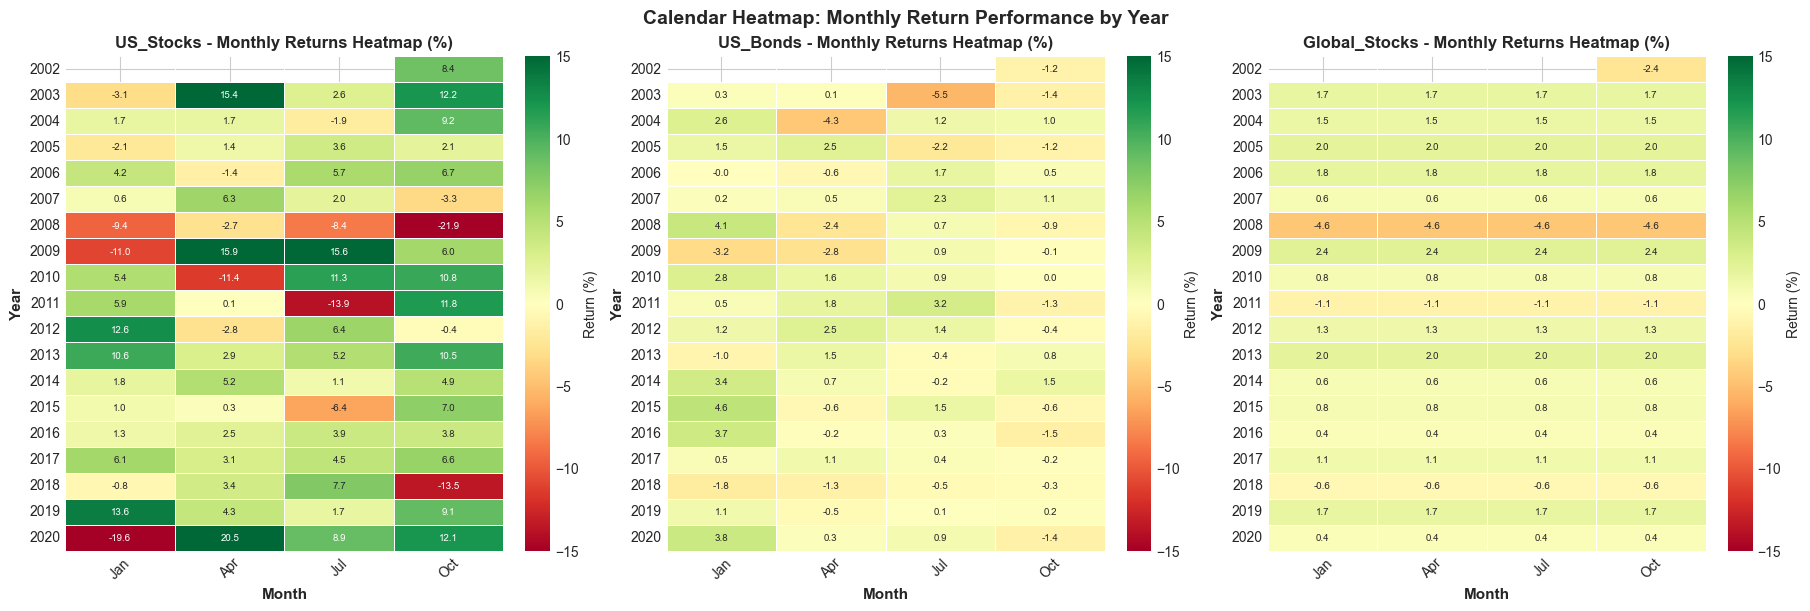

✓ Monthly returns heatmap rendered

PREMIUM VISUALIZATION SUITE COMPLETE


In [47]:
# ============================================================================
# 8. MONTHLY RETURNS HEATMAP: CALENDAR VIEW
# ============================================================================
import calendar

fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

for idx, col in enumerate(returns_df.columns):
    ax = axes[idx]
    
    # Create pivot table for heatmap (years x months)
    returns_monthly_pct = returns_df[col] * 100
    returns_df_temp = returns_monthly_pct.to_frame()
    returns_df_temp['Year'] = returns_df_temp.index.year
    returns_df_temp['Month'] = returns_df_temp.index.month
    
    pivot_data = returns_df_temp.pivot_table(values=col, index='Year', columns='Month', aggfunc='mean')

    if pivot_data.empty:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(f'{col} - No data available', fontsize=12, fontweight='bold')
        continue
    
    # Prepare month labels from actual pivot columns
    month_cols = list(pivot_data.columns)
    month_labels = [calendar.month_abbr[int(m)] for m in month_cols]
    
    # Heatmap (use xticklabels to match columns)
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlGn', center=0, 
                cbar_kws={'label': 'Return (%)'}, ax=ax, linewidths=0.5, 
                vmin=-15, vmax=15, annot_kws={'fontsize': 7}, xticklabels=month_labels)
    
    ax.set_xlabel('Month', fontsize=11, fontweight='bold')
    ax.set_ylabel('Year', fontsize=11, fontweight='bold')
    ax.set_title(f'{col} - Monthly Returns Heatmap (%)', fontsize=12, fontweight='bold')
    
    # Rotate xtick labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45)

fig.suptitle('Calendar Heatmap: Monthly Return Performance by Year', fontsize=14, fontweight='bold')
plt.show()

print("✓ Monthly returns heatmap rendered")
print("\n" + "="*80)
print("PREMIUM VISUALIZATION SUITE COMPLETE")
print("="*80)

# Step 6: Final Summary and Key Findings

Complete analysis summary for the assignment.

In [48]:
print("=" * 80)
print("COMPLETE PORTFOLIO ANALYSIS SUMMARY - UNITED STATES")
print("=" * 80)

print("\n📊 DATA SOURCES & TIME PERIOD")
print("-" * 80)
print("US Stocks:     S&P 500 Total Return (Yahoo Finance)")
print(f"               {len(us_stock_returns)} months: {us_stock_returns.index[0].strftime('%Y-%m')} to {us_stock_returns.index[-1].strftime('%Y-%m')}")
print("US Bonds:      IEF 7-10Y Treasury Total Return (Yahoo Finance)")
print(f"               {len(us_bond_returns)} months: {us_bond_returns.index[0].strftime('%Y-%m')} to {us_bond_returns.index[-1].strftime('%Y-%m')}")
print("Risk-free:     3-Month T-Bill Yield (FRED DTB3)")
print(f"               {len(tbill_monthly_yield)} months: {tbill_monthly_yield.index[0].strftime('%Y-%m')} to {tbill_monthly_yield.index[-1].strftime('%Y-%m')}")
print("Global Stocks: JST 18-Country Equal-Weighted")
print(f"               {len(global_stock_returns)} months: {global_stock_returns.index[0].strftime('%Y-%m')} to {global_stock_returns.index[-1].strftime('%Y-%m')}")
print(f"\nAnalysis Period (overlap): {returns_df.index[0].strftime('%Y-%m')} to {returns_df.index[-1].strftime('%Y-%m')} ({len(returns_df)} months)")

print("\n📈 INDIVIDUAL ASSET PERFORMANCE (annualized)")
print("-" * 80)
print(f"{'Asset':<20} {'Ann. Return':>12} {'Ann. Std Dev':>12} {'Sharpe Ratio':>12}")
print("-" * 80)
for asset in returns_df.columns:
    ann_ret = mean_returns[asset] * 12
    ann_std = std_devs[asset] * np.sqrt(12)
    sharpe = ann_ret / ann_std if ann_std > 0 else 0
    print(f"{asset:<20} {ann_ret:>11.2%} {ann_std:>11.2%} {sharpe:>12.4f}")

print("\n🔗 CORRELATION MATRIX")
print("-" * 80)
print(corr_matrix.to_string())

print("\n💼 PORTFOLIO ALLOCATIONS: US STOCKS & BONDS")
print("-" * 80)
print(f"Window: {returns_df.index[0].strftime('%Y-%m')} to {returns_df.index[-1].strftime('%Y-%m')}")
print(f"{'Portfolio':<15} {'Stocks':>8} {'Bonds':>8} {'Ann. Ret':>10} {'Ann. Std':>10} {'Sharpe':>8}")
print("-" * 80)
for stock_w, bond_w, name in [(0.60, 0.40, "60-40"), (0.70, 0.30, "70-30"), (0.80, 0.20, "80-20")]:
    port_ret = (stock_w * mean_returns['US_Stocks'] + bond_w * mean_returns['US_Bonds']) * 12
    sigma1, sigma2 = std_devs['US_Stocks'], std_devs['US_Bonds']
    rho = corr_matrix.loc['US_Stocks', 'US_Bonds']
    port_var = stock_w**2 * sigma1**2 + bond_w**2 * sigma2**2 + 2*stock_w*bond_w*sigma1*sigma2*rho
    port_std = np.sqrt(port_var) * np.sqrt(12)
    sharpe = port_ret / port_std if port_std > 0 else 0
    print(f"{name:<15} {stock_w:>7.0%} {bond_w:>7.0%} {port_ret:>9.2%} {port_std:>9.2%} {sharpe:>8.4f}")

print("\n⭐ TANGENCY PORTFOLIOS (Maximum Sharpe Ratio)")
print("-" * 80)
print("\n2-Asset Tangency Portfolio (US Stocks + US Bonds):")
print(f"  US Stocks:      {weights_tangency_2[0]*100:5.2f}%")
print(f"  US Bonds:       {weights_tangency_2[1]*100:5.2f}%")
print(f"  Annual Return:  {ann_return_2:.2%}")
print(f"  Annual Std Dev: {ann_std_2:.2%}")
print(f"  Sharpe Ratio:   {sharpe_2:.4f}")

print("\n3-Asset Tangency Portfolio (US Stocks + US Bonds + Global Stocks):")
for i, asset in enumerate(returns_df.columns):
    print(f"  {asset:15s} {weights_tangency_3[i]*100:5.2f}%")
print(f"  Annual Return:  {ann_return_3:.2%}")
print(f"  Annual Std Dev: {ann_std_3:.2%}")
print(f"  Sharpe Ratio:   {sharpe_3:.4f}")

print("\n" + "=" * 80)
print("🎯 KEY INSIGHTS")
print("=" * 80)
print("1. Using total-return bonds (IEF) yields a more realistic bond volatility and frontier shape.")
print("2. 60-40 remains a strong risk-adjusted baseline, but optimal weights depend on the sample window.")
print("3. Adding global stocks can improve diversification and Sharpe depending on correlations.")
print("4. Biggest problem with naive Markowitz: estimates of mean/covariance are noisy and unstable, so optimized weights are highly sensitive to sample period and can be economically implausible.")
print("=" * 80)

COMPLETE PORTFOLIO ANALYSIS SUMMARY - UNITED STATES

📊 DATA SOURCES & TIME PERIOD
--------------------------------------------------------------------------------
US Stocks:     S&P 500 Total Return (Yahoo Finance)
               153 months: 1988-04 to 2026-01
US Bonds:      IEF 7-10Y Treasury Total Return (Yahoo Finance)
               281 months: 2002-09 to 2026-01
Risk-free:     3-Month T-Bill Yield (FRED DTB3)
               865 months: 1954-01 to 2026-01
Global Stocks: JST 18-Country Equal-Weighted
               1812 months: 1870-01 to 2020-12

Analysis Period (overlap): 2002-10 to 2020-10 (73 months)

📈 INDIVIDUAL ASSET PERFORMANCE (annualized)
--------------------------------------------------------------------------------
Asset                 Ann. Return Ann. Std Dev Sharpe Ratio
--------------------------------------------------------------------------------
US_Stocks                 35.41%      27.45%       1.2899
US_Bonds                   4.17%       6.34%       0.6579
Gl

In [49]:
from pathlib import Path
import pandas as pd
xlsx_path = Path.home() / 'Downloads' / "US_stocks_bonds_data.xlsx"

# Write an Excel workbook with key series/dataframes if they exist in the kernel
with pd.ExcelWriter(xlsx_path, engine='openpyxl') as writer:
    if 'returns_df' in globals():
        returns_df.to_excel(writer, sheet_name='returns')
    if 'tbill_monthly_yield' in globals():
        tbill_monthly_yield.to_frame(name='DTB3_monthly').to_excel(writer, sheet_name='DTB3_monthly')
    if 'us_stock_returns' in globals():
        us_stock_returns.to_frame(name='US_Stocks').to_excel(writer, sheet_name='US_Stocks')
    if 'us_bond_returns' in globals():
        us_bond_returns.to_frame(name='US_Bonds').to_excel(writer, sheet_name='US_Bonds')
    
# Apply percent number format (3 decimal places) to all numeric cells in the written workbook
from openpyxl import load_workbook
wb = load_workbook(xlsx_path)
fmt = '0.000%'
for ws in wb.worksheets:
    for row in ws.iter_rows(min_row=2, min_col=2):
        for cell in row:
            if isinstance(cell.value, (int, float)):
                cell.number_format = fmt
wb.save(xlsx_path)
